# MNIST 手寫辨識：簡單人工神經網路 (ANN)

這個 Colab Notebook 示範如何使用 **一個隱藏層 + 一個輸出層** 的人工神經網路，完成 MNIST 手寫數字辨識。

資料來源為兩個 CSV 檔：
- `mnist_train.csv`：訓練資料
- `mnist_test.csv`：測試資料

模型設計：
- 輸入層：784 維 (28x28 灰階像素攤平)
- 隱藏層：ReLU 啟動函數
- 輸出層：Softmax，輸出 10 維 (數字 0~9)
- 標籤(label) 會轉成 **one-hot 編碼**

最後會提供一段程式碼，讓你可以指定一筆測試資料：
- 顯示那張手寫圖片
- 顯示模型辨識結果（預測數字）

## 1. 環境準備與套件載入

在 Colab 上我們需要的主要套件：
- `pandas`：讀取 CSV 資料
- `numpy`：數值運算
- `matplotlib`：畫圖 (顯示手寫圖片)
- `tensorflow` / `keras`：建立、訓練人工神經網路模型

In [3]:
# 匯入必要套件
import numpy as np                 # 做數值與陣列運算
import pandas as pd               # 讀取 CSV 資料
import matplotlib.pyplot as plt   # 畫圖（顯示手寫數字）

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 顯示目前 TensorFlow 版本，確認環境
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## 2. 讀取 MNIST CSV 資料

請先將 `mnist_train.csv` 與 `mnist_test.csv` 上傳到 Colab 的工作目錄（左側檔案區）。

每一筆資料格式：
- 第 0 欄：標籤 (label)，數字 0~9
- 第 1~784 欄：28x28 灰階像素，值介於 0~255

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# === 請確認檔名與路徑 ===
# 一般情況下，如果檔案就在 Colab 目前目錄，填檔名即可。
train_path = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_train.csv"
test_path  = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_test.csv"

# 使用 pandas 讀取 CSV 檔
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)  # (筆數, 785)
print("Test shape:",  test_df.shape)

# 看前幾列確認格式是否正確
train_df.head()

Train shape: (60000, 785)
Test shape: (10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. 資料前處理

步驟說明：
1. 從 `DataFrame` 轉為 `numpy` 陣列。
2. 切出特徵 `X`（像素）與標籤 `y`（數字 0~9）。
3. 將像素值從 0~255 正規化到 0~1，幫助模型訓練。
4. 將 `X` 另外 reshape 成 28x28，方便之後顯示圖片用。
5. 將 `y` 轉成 one-hot 編碼。

In [6]:
# 將 DataFrame 轉成 numpy 陣列，資料型態用 float32 方便後續運算
train_data = train_df.values.astype(np.float32)
test_data  = test_df.values.astype(np.float32)

# 第 0 欄是標籤（0~9）
y_train_int = train_data[:, 0].astype(int)
y_test_int  = test_data[:, 0].astype(int)

# 第 1~784 欄是像素
X_train = train_data[:, 1:]
X_test  = test_data[:, 1:]

# 像素從 0~255 正規化到 0~1
X_train = X_train / 255.0
X_test  = X_test  / 255.0

print("X_train shape:", X_train.shape)  # (n_train, 784)
print("y_train_int shape:", y_train_int.shape)
print("X_test shape:", X_test.shape)
print("y_test_int shape:", y_test_int.shape)

# 另外準備 28x28 的影像版本，以方便畫圖用（模型仍使用 784 維）
X_train_img = X_train.reshape(-1, 28, 28)
X_test_img  = X_test.reshape(-1, 28, 28)

print("X_train_img shape:", X_train_img.shape)

X_train shape: (60000, 784)
y_train_int shape: (60000,)
X_test shape: (10000, 784)
y_test_int shape: (10000,)
X_train_img shape: (60000, 28, 28)


In [7]:
# 將整數標籤轉成 one-hot 編碼
# 例如：3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
num_classes = 10
y_train = keras.utils.to_categorical(y_train_int, num_classes)
y_test  = keras.utils.to_categorical(y_test_int,  num_classes)

print("y_train (one-hot) shape:", y_train.shape)
print("y_test  (one-hot) shape:", y_test.shape)

y_train (one-hot) shape: (60000, 10)
y_test  (one-hot) shape: (10000, 10)


### 小測試：顯示一張訓練圖片

確認我們的資料是否正確：
- 使用 `matplotlib` 顯示其中一張 28x28 灰階影像。
- 同時印出對應的標籤（真實數字）。

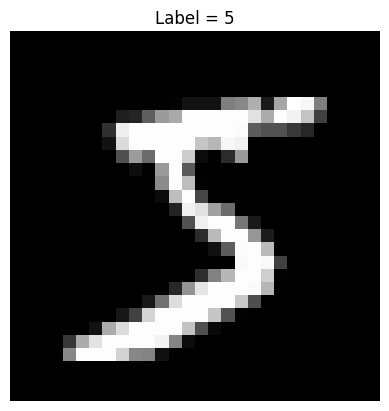

In [8]:
# 顯示第 0 筆訓練資料的圖片和標籤
idx = 0  # 可以自己改成別的整數

plt.imshow(X_train_img[idx], cmap="gray")
plt.title(f"Label = {y_train_int[idx]}")
plt.axis("off")
plt.show()

## 4. 建立 ANN 模型

我們使用 `tf.keras` 的 `Sequential` 模型：

1. **輸入層**：形狀為 `(784,)`，代表 28x28 攤平成一維。
2. **隱藏層**：
   - `Dense(units)` 全連接層
   - 使用 `activation='relu'` 做非線性轉換
3. **輸出層**：
   - `Dense(10)`，對應 0~9 十個類別
   - 使用 `activation='softmax'`，輸出每個類別的機率

損失函數與優化方法：
- Loss：`categorical_crossentropy`（因為我們使用 one-hot 標籤）
- Optimizer：`adam`（常用的自適應學習率方法）

In [9]:
# 建立一個簡單的 ANN 模型

model = keras.Sequential([
    # 隱藏層：128 個神經元，可依需求調整
    layers.Dense(128, activation="relu", input_shape=(784,)),

    # 輸出層：10 個神經元 (0~9)，使用 softmax 輸出機率
    layers.Dense(10, activation="softmax")
])

# 查看模型結構
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 編譯模型
# loss: 使用類別交叉熵 (categorical_crossentropy) 搭配 one-hot 標籤
# optimizer: 使用 Adam
# metrics: 監看 accuracy 方便了解訓練表現

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

## 5. 訓練模型

我們使用訓練資料 (`mnist_train.csv`) 進行訓練，並保留一部分訓練資料作為驗證集（`validation_split`）。

你可以調整：
- `epochs`：訓練週期數
- `batch_size`：每次梯度更新所使用的樣本數

In [16]:
# 設定訓練參數
epochs = 10      # 訓練週期數，可依需求增減
batch_size = 64 # 批次大小

# 開始訓練模型，並從訓練資料中切出 10% 當作驗證資料
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9879 - loss: 0.0386 - val_accuracy: 0.9772 - val_loss: 0.1032
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9803 - val_loss: 0.0939
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9793 - val_loss: 0.1009
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9800 - val_loss: 0.0996
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9798 - val_loss: 0.1040
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.9795 - val_loss: 0.1056
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9803 - val_loss: 0.0999
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.

### 訓練過程視覺化

把訓練過程中的 loss / accuracy 畫出來，觀察模型是否有收斂、是否過度擬合。

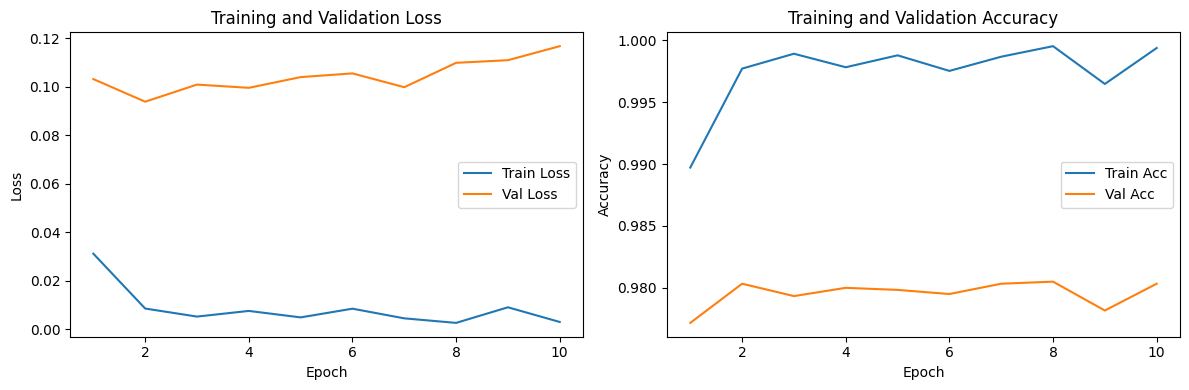

In [17]:
# 從 history 物件中取出訓練與驗證的 loss / accuracy
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]
train_acc  = history.history["accuracy"]
val_acc    = history.history["val_accuracy"]

epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Loss 曲線
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Acc")
plt.plot(epochs_range, val_acc,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## 6. 使用測試資料評估模型

此處使用 `mnist_test.csv` 的資料，作為真正獨立的測試集：
- 不參與訓練
- 專門用來評估模型的泛化能力

In [18]:
# 在測試集上評估模型表現
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1091
Test Accuracy: 0.9782


## 7. 單一樣本測試與圖片顯示

我們希望可以：
1. 指定一個測試資料的索引 `idx`。
2. 顯示該筆資料的 28x28 手寫圖片。
3. 顯示模型預測的數字與真實標籤。

你可以自由修改 `idx` 的值，來測試不同的圖片。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


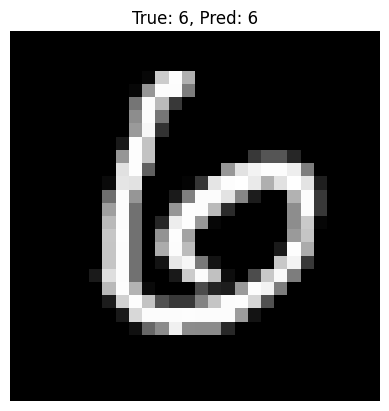

Prediction probabilities (for digits 0~9):
0: 0.0000
1: 0.0000
2: 0.0000
3: 0.0000
4: 0.0000
5: 0.0000
6: 1.0000
7: 0.0000
8: 0.0000
9: 0.0000


In [21]:
# 指定要查看的測試樣本 index
# 可以更改這個數字，例如 0, 1, 2, 100, 999 等，只要在測試資料筆數範圍內即可
idx = 11

# 取出影像資料 (28x28) 與一維向量 (784) 以及標籤
img_2d = X_test_img[idx]            # 給 matplotlib 顯示用 (28x28)
img_1d = X_test[idx].reshape(1, -1) # 給模型預測用 (1, 784)
true_label_int = y_test_int[idx]

# 使用模型進行預測
pred_prob = model.predict(img_1d)   # 得到 10 維機率
pred_label_int = np.argmax(pred_prob, axis=1)[0]

# 顯示圖片
plt.imshow(img_2d, cmap="gray")
plt.axis("off")
plt.title(f"True: {true_label_int}, Pred: {pred_label_int}")
plt.show()

# 顯示完整的機率分佈（可選）
print("Prediction probabilities (for digits 0~9):")
for d in range(10):
    print(f"{d}: {pred_prob[0, d]:.4f}")

---
到這裡，我們已經完成：
1. 從 CSV 讀取 MNIST 手寫資料。
2. 前處理（正規化、one-hot 編碼）。
3. 建立一個隱藏層 + 一個輸出層的 ANN 模型（ReLU + Softmax）。
4. 訓練並視覺化 Loss / Accuracy。
5. 在測試集上評估模型表現。
6. 指定一筆測試資料，顯示圖片並輸出預測結果。

你可以依照需求自行調整：
- 隱藏層神經元數量
- 訓練週期數 (epochs)
- 批次大小 (batch_size)
並觀察模型的表現變化。

## 額外增加：混淆矩陣的顯示



In [ ]:
# 步驟 1：匯入 sklearn 中的混淆矩陣工具
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
# 步驟 2：用模型在測試資料上預測
# 這裡輸出的是每一類（0~9）的機率
y_pred_prob = model.predict(X_test)

# 將機率最大的位置取出，得到模型預測的「數字標籤」
# 例如 [0.01, 0.02, 0.8, ...] -> 2
y_pred_int = np.argmax(y_pred_prob, axis=1)

# 確認一下形狀
print("y_test_int shape:", y_test_int.shape)  # 真實標籤
print("y_pred_int shape:", y_pred_int.shape)  # 預測標籤


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_test_int shape: (10000,)
y_pred_int shape: (10000,)


In [ ]:
# 步驟 3：計算混淆矩陣
# rows: 真實標籤 (0~9)
# cols: 預測標籤 (0~9)
cm = confusion_matrix(y_test_int, y_pred_int)

print("Confusion Matrix (raw counts):")
print(cm)


Confusion Matrix (raw counts):
[[ 969    0    1    0    2    0    2    2    3    1]
 [   0 1126    3    0    0    1    2    0    3    0]
 [   3    2 1011    3    3    0    2    5    3    0]
 [   0    0    3  989    0    5    0    4    1    8]
 [   3    0    3    1  965    0    1    1    2    6]
 [   2    1    0    5    2  869    6    0    4    3]
 [   5    2    2    1    4    3  940    0    1    0]
 [   1    4   10    4    0    0    0 1004    0    5]
 [   6    1    2    6    6    3    2    5  940    3]
 [   1    6    0    6   12    3    0    5    3  973]]


<Figure size 600x600 with 0 Axes>

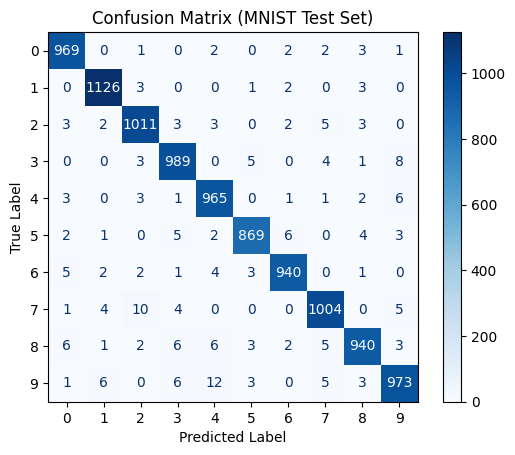

In [ ]:
# 步驟 4A：用 ConfusionMatrixDisplay 畫出混淆矩陣
labels = list(range(10))  # 0~9

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")  # values_format="d" 表示顯示整數
plt.title("Confusion Matrix (MNIST Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# 步驟 5（可選）：分類報告
print("Classification Report:")
print(classification_report(y_test_int, y_pred_int, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9788    0.9888    0.9838       980
           1     0.9860    0.9921    0.9890      1135
           2     0.9768    0.9797    0.9782      1032
           3     0.9744    0.9792    0.9768      1010
           4     0.9708    0.9827    0.9767       982
           5     0.9830    0.9742    0.9786       892
           6     0.9843    0.9812    0.9827       958
           7     0.9786    0.9767    0.9776      1028
           8     0.9792    0.9651    0.9721       974
           9     0.9740    0.9643    0.9691      1009

    accuracy                         0.9786     10000
   macro avg     0.9786    0.9784    0.9785     10000
weighted avg     0.9786    0.9786    0.9786     10000

